In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import warnings
import os
import re
from sklearn.metrics import roc_curve, roc_auc_score
from math import ceil

pd.set_option('display.max_colwidth', None)
tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
labels = ['toxicity','severe_toxicity','obscene','threat','insult','identity_attack']

In [80]:
json_folder_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-War-Combined/lightning_logs/version_19/checkpoints/converted'

In [81]:
multi_epoch_data = {}

for filename in os.listdir(json_folder_path):
    if filename.endswith(".json"):
        epoch = int(filename.split('=')[1].split('-')[0])
        file_path = os.path.join(json_folder_path, filename)
        with open(file_path) as f:
            data = json.load(f)
            multi_epoch_data[epoch] = data

multi_epoch_data = dict(sorted(multi_epoch_data.items()))

print(f"Loaded {len(multi_epoch_data)} json files")

Loaded 10 json files


# Graphs

In [9]:
def plot_histogram(target_scores, pred_scores):
    nrows = ceil((len(target_scores) + 1) / 3)
    height = 12 * nrows / 3
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(12, height))
    axs = axs.flatten()
    final_plot = len(target_scores)

    for i, (label, scores) in enumerate(target_scores.items()):
        axs[i].hist(scores, bins=50, alpha=0.5, color='r', range=(0, 1), label="Targets")
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for "{label}"')
        axs[i].set_yscale('log')
    
    for i, (label, scores) in enumerate(pred_scores.items()):
        axs[i].hist(scores, bins=50, alpha=0.5, range=(0, 1), label="Predictions")
        axs[i].legend()

    all_target_scores = [value for values in target_scores.values() for value in values]
    all_pred_scores = [value for values in pred_scores.values() for value in values]
    axs[final_plot].hist(all_target_scores, bins=50, alpha=0.5, color='r', range=(0, 1), label="Targets")
    axs[final_plot].hist(all_pred_scores, bins=50, alpha=0.5, range=(0, 1), label="Predictions")
    axs[final_plot].legend()
    axs[final_plot].set_xlabel('Value')
    axs[final_plot].set_ylabel('Frequency')
    axs[final_plot].set_title("Histogram for All Prompts")
    axs[final_plot].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [10]:
def plot_roc_auc(target_scores, pred_scores):
    nrows = ceil((len(target_scores) + 1) / 3)
    height = 12 * nrows / 3
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(12, height))
    axs = axs.flatten()
    final_plot = len(target_scores)

    for i, (label, scores) in enumerate(target_scores.items()):
        target_score = scores
        pred_score = pred_scores[label]

        fpr, tpr, thresholds = roc_curve(target_score,  pred_score)
        auc = roc_auc_score(target_score, pred_score)
        axs[i].plot(fpr,tpr,label=f"AUC={auc:.4f}")
        axs[i].legend()
        axs[i].set_xlabel('True Positive Rate')
        axs[i].set_ylabel('False Positive Rate')
        axs[i].set_title(f'ROC-AUC for "{label}"')

    all_target_scores = [value for values in target_scores.values() for value in values]
    all_pred_scores = [value for values in pred_scores.values() for value in values]
    fpr, tpr, thresholds = roc_curve(all_target_scores,  all_pred_scores)
    auc = roc_auc_score(all_target_scores, all_pred_scores)
    axs[final_plot].plot(fpr,tpr,label=f"AUC={auc:.4f}")
    axs[final_plot].legend()
    axs[final_plot].set_xlabel('True Positive Rate')
    axs[final_plot].set_ylabel('False Positive Rate')
    axs[final_plot].set_title("ROC-AUC for All Labels")

    plt.tight_layout()
    plt.show()

In [74]:
def plot_score_graph(scores, x_label, title, score_labels):
    for l in score_labels:
        individual_score = [scores[e][l] for e in scores]
        plt.plot(list(scores.keys()), individual_score, label=l)

    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [75]:
def plot_threshold_score_graph(scores, x_label, title):
    for l in scores.keys():
        plt.plot(list(range(len(scores[l]))), scores[l], label=l)

    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histograms + ROC-AUC Graphs

## Jigsaw Data

In [ ]:
model_results = results['jigsaw']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)


## Secondary Positive Data

In [ ]:
model_results = results['secondary_positive']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)


## Secondary Neutral Data

In [ ]:
model_results = results['secondary_neutral']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)


## All data

In [ ]:
model_results_jigsaw = results['jigsaw']['data_points']
model_results_secondary_positive = results['secondary_positive']['data_points']
model_results_secondary_neutral = results['secondary_neutral']['data_points']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results_jigsaw] + \
        [s['target'][i] for s in model_results_secondary_positive] + \
        [s['target'][i] for s in model_results_secondary_neutral]
    predictions[label] = [s['prediction'][i] for s in model_results_jigsaw] + \
        [s['prediction'][i] for s in model_results_secondary_positive] + \
        [s['prediction'][i] for s in model_results_secondary_neutral]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)

# Histogram across Epochs

In [ ]:
targets = {}
predictions = {}
for epoch, data in multi_epoch_data.items():
    nested_values = [s['target'] for s in data['jigsaw']['data_points']]
    targets[f"Epoch {epoch}"] = [item for sublist in nested_values for item in sublist]
    nested_values = [s['prediction'] for s in data['jigsaw']['data_points']]
    predictions[f"Epoch {epoch}"] = [item for sublist in nested_values for item in sublist]

plot_histogram(targets, predictions)


# Scores across Epochs

In [76]:
score_labels = [
    "F1", 
    "Recall", 
    "Precision", 
    # "AUC"
]
data_sets = ['jigsaw', 'secondary_neutral', 'secondary_positive', 'ALL']

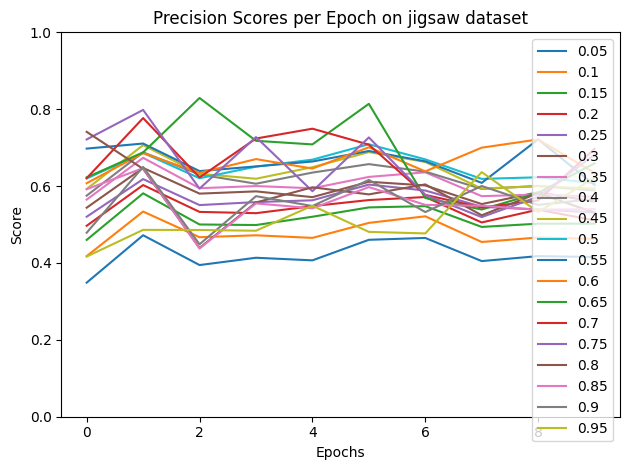

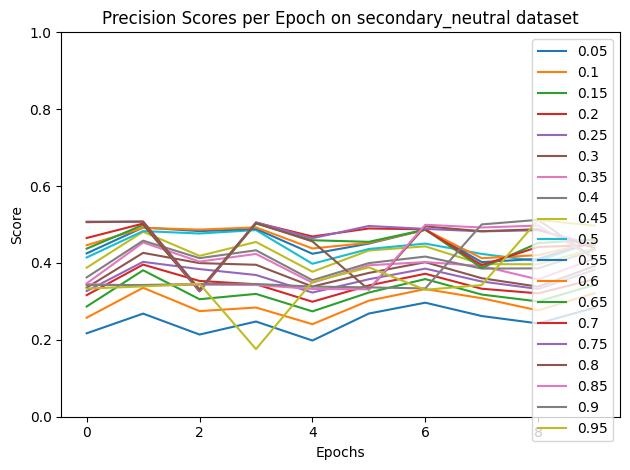

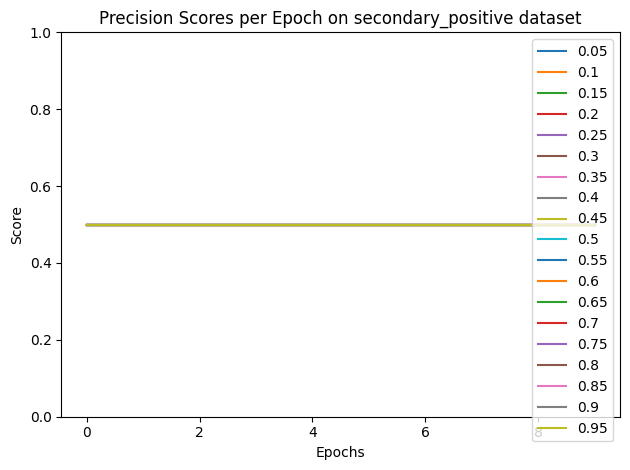

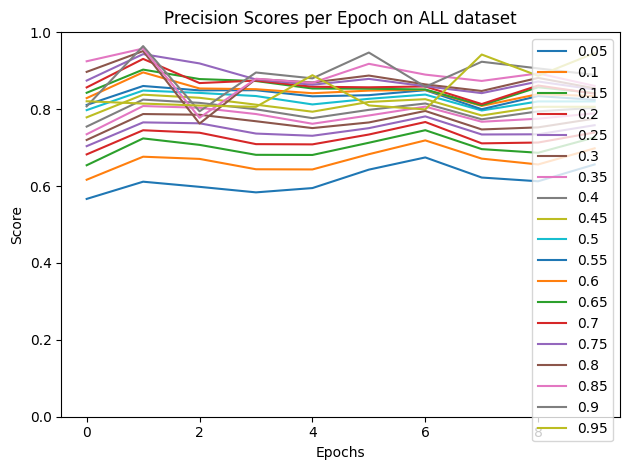

In [84]:
LABEL = "Precision"

for data_name in data_sets:
    threshold_scores = {}
    for epoch, all_data in multi_epoch_data.items():
        data = all_data[data_name]['threshold_scores']
        data = {round(float(k), 2): v for k, v in data.items()}
        for threshold, scores in data.items():
            if 0 < threshold < 0.99:
                if threshold in threshold_scores.keys():
                    threshold_scores[threshold].append(scores[f"mean_{LABEL.lower()}"])
                else:
                    threshold_scores[threshold] = [scores[f"mean_{LABEL.lower()}"]]

    plot_threshold_score_graph(
        threshold_scores, 
        x_label="Epochs", 
        title=f"{LABEL} Scores per Epoch on {data_name} dataset", 
    )

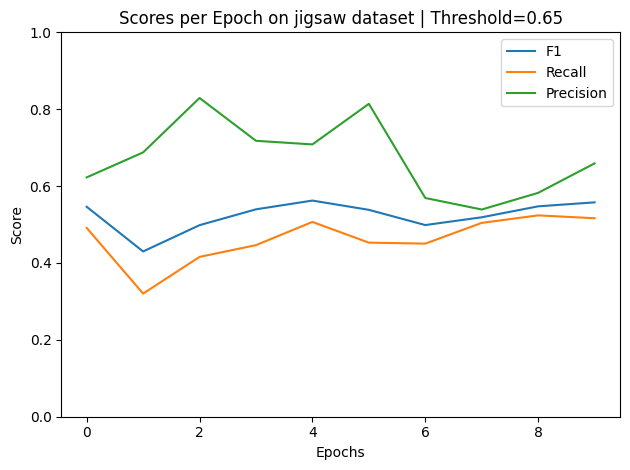

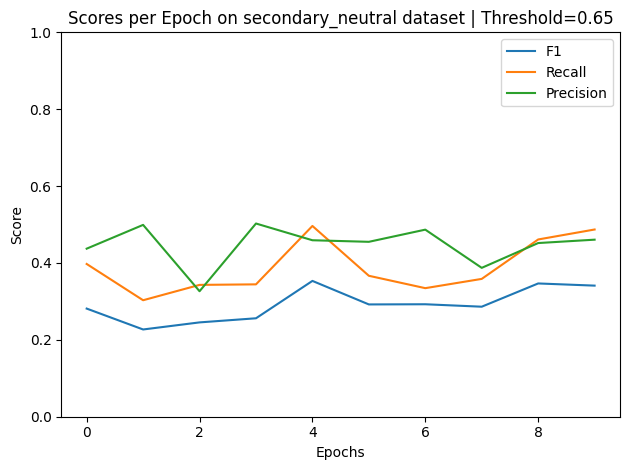

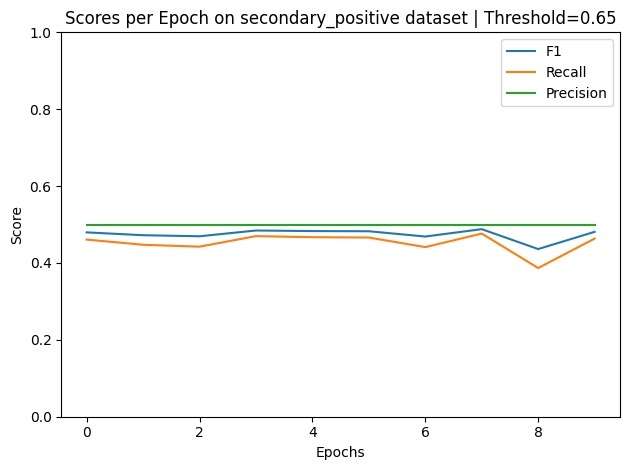

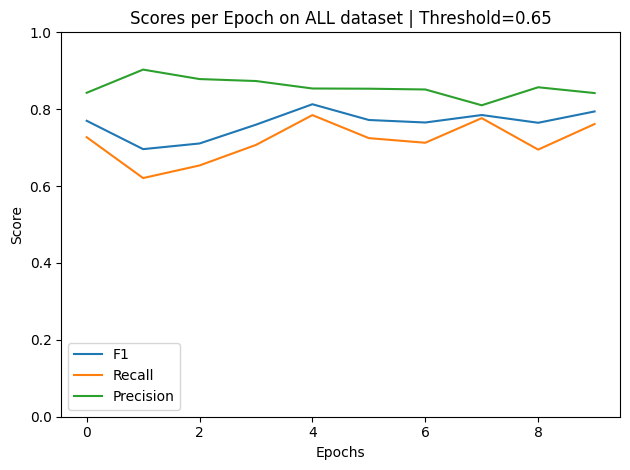

In [82]:
threshold = 0.65

for data_name in data_sets:
    mean_scores = {}
    for epoch, all_data in multi_epoch_data.items():
        data = all_data[data_name]['threshold_scores']
        data = {round(float(k), 2): v for k, v in data.items()}[threshold]
        mean_scores[int(epoch)] = {
            l: data[f"mean_{l.lower()}"] for l in score_labels
        }

    plot_score_graph(
        mean_scores, 
        x_label="Epochs", 
        title=f"Scores per Epoch on {data_name} dataset | Threshold={threshold}", 
        score_labels=score_labels
    )

# Scores across Thresholds

dict_keys(['jigsaw', 'secondary_positive', 'secondary_neutral', 'ALL'])
Dataset: jigsaw
	F1           0.6569       0.2         
	Recall       0.8721       0.05        
	Precision    0.8927       0.65        


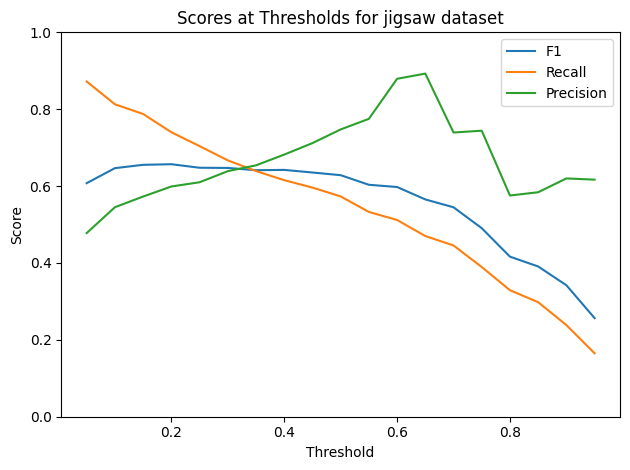

Dataset: secondary_neutral
	F1           0.605        0.15        
	Recall       0.7022       0.05        
	Precision    0.707        0.3         


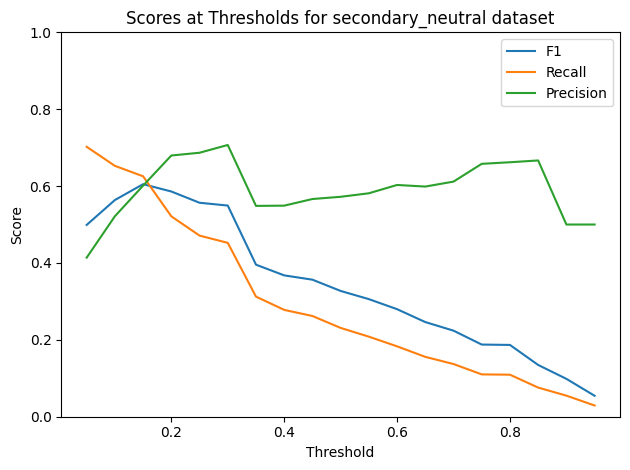

Dataset: secondary_positive
	F1           0.0123       0.05        
	Recall       0.0063       0.05        
	Precision    0.5          0.05        


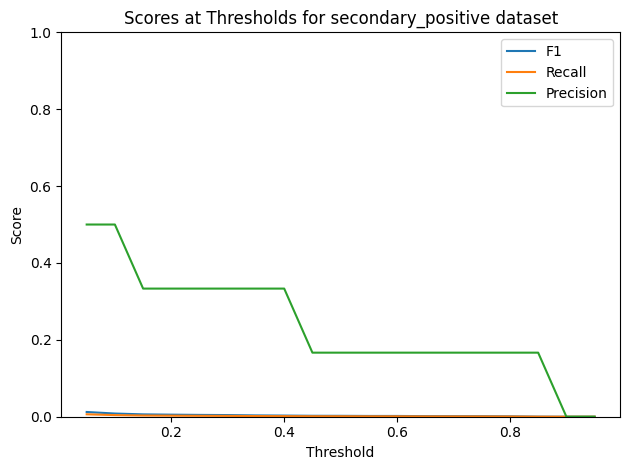

Dataset: ALL
	F1           0.3433       0.35        
	Recall       0.4494       0.05        
	Precision    0.8475       0.65        


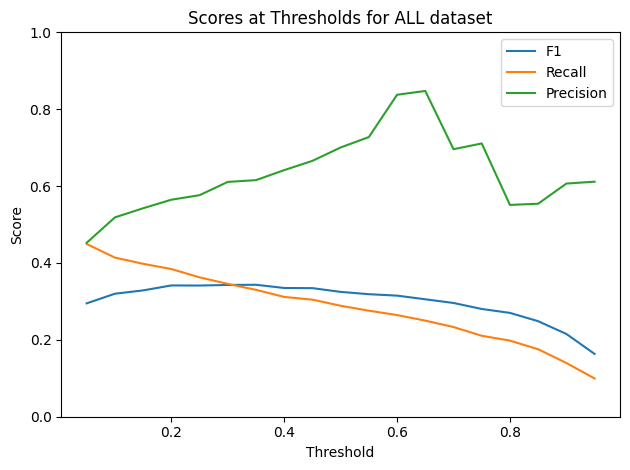

In [79]:
EPOCH = 5

results = multi_epoch_data[EPOCH]
print(results.keys())
for data_name in data_sets:
    data = results[data_name]['threshold_scores']
    mean_scores = {}
    for threshold, all_data in data.items():
        mean_scores[round(float(threshold), 2)] = {
            l: all_data[f"mean_{l.lower()}"] for l in score_labels
        }
    
    print(f"Dataset: {data_name}")
    for l in score_labels:
        max_score = max(mean_scores, key=lambda x: mean_scores[x][l])
        print(f"\t{l:<12} {round(mean_scores[max_score][l], 4):<12} {max_score:<12}")

    plot_score_graph(mean_scores, "Threshold", f"Scores at Thresholds for {data_name} dataset", score_labels)

# Sub-Topic Scores

In [85]:
results_paths = [
    '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/version_0/checkpoints/converted/epoch=0-step=3309.test_results.json',
    '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/version_0/checkpoints/converted/epoch=0-step=3875.test_results.json',
    '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/version_0/checkpoints/converted/epoch=0-step=3875.test_results.json',
    '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/version_0/checkpoints/converted/epoch=0-step=3875.test_results.json',
]

In [108]:
sub_topic_data = {}

for filename in results_paths:
    match = re.search(r"ALBERT-Topic-(\d+)", filename)
    if match:
        topic_num = match.group(1)
        with open(file_path) as f:
            data = json.load(f)
            reduced_data = {}
            for data_name in data_sets:
                d = data[data_name]['threshold_scores']
                d = {round(float(t), 2): dd for t, dd in d.items()}
                reduced_data[data_name] = d[0.65]
            sub_topic_data[int(topic_num)] = reduced_data

sub_topic_data = dict(sorted(sub_topic_data.items()))
print(f"Loaded {len(sub_topic_data)} json files")

Loaded 4 json files


In [110]:
print(sub_topic_data[4])

{'jigsaw': {'toxicity': {'auc': 0.9833849983561129, 'f1': 0.8007380073800738, 'recall': 0.7695035460992907, 'precision': 0.8346153846153846, 'accuracy': 0.964}, 'severe_toxicity': {'auc': 0.9901983193277311, 'f1': 0.0, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.9916666666666667}, 'obscene': {'auc': 0.9918409356725146, 'f1': 0.7238805970149254, 'recall': 0.6466666666666666, 'precision': 0.8220338983050848, 'accuracy': 0.9753333333333334}, 'threat': {'auc': 0.9938209752839011, 'f1': 0.2222222222222222, 'recall': 0.16666666666666666, 'precision': 0.3333333333333333, 'accuracy': 0.9976666666666667}, 'insult': {'auc': 0.9851499567985392, 'f1': 0.6788321167883211, 'recall': 0.6503496503496503, 'precision': 0.7099236641221374, 'accuracy': 0.9706666666666667}, 'identity_attack': {'auc': 0.9861649258760108, 'f1': 0.5660377358490566, 'recall': 0.46875, 'precision': 0.7142857142857143, 'accuracy': 0.9923333333333333}, 'mean_auc': 0.9884266852191349, 'mean_f1': 0.4986184465424332, 'mean_recall

In [121]:
from prettytable import PrettyTable

headers = ["Sub-Topic", "Dataset", "Class", "F1", "Recall", "Precision"]

for model, metrics in sub_topic_data.items():
    table = PrettyTable(headers)
    for metric, data in metrics.items():
        for label in labels:
            values = data[label]
            f1 = round(values["f1"], 4)
            recall = round(values["recall"], 4)
            precision = round(values["precision"], 4)
            table.add_row([model, metric, label, f1, recall, precision])
    print(table)


+-----------+--------------------+-----------------+--------+--------+-----------+
| Sub-Topic |      Dataset       |      Class      |   F1   | Recall | Precision |
+-----------+--------------------+-----------------+--------+--------+-----------+
|     4     |       jigsaw       |     toxicity    | 0.8007 | 0.7695 |   0.8346  |
|     4     |       jigsaw       | severe_toxicity |  0.0   |  0.0   |    0.0    |
|     4     |       jigsaw       |     obscene     | 0.7239 | 0.6467 |   0.822   |
|     4     |       jigsaw       |      threat     | 0.2222 | 0.1667 |   0.3333  |
|     4     |       jigsaw       |      insult     | 0.6788 | 0.6503 |   0.7099  |
|     4     |       jigsaw       | identity_attack | 0.566  | 0.4688 |   0.7143  |
|     4     | secondary_neutral  |     toxicity    | 0.6647 | 0.5403 |   0.8636  |
|     4     | secondary_neutral  | severe_toxicity |  0.0   |  0.0   |    0.0    |
|     4     | secondary_neutral  |     obscene     | 0.7971 | 0.6875 |   0.9483  |
|   